In [50]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_probability, plot_corner_emcee, plot_walker_emcee, \
     display_median_from_chain, log_likelihood
import sys 
import matplotlib.pyplot as plt
import astropy.units as u

In [10]:
#import brightness and error for each Flare and TRAPPIST-1
flare1 = np.genfromtxt("../results/values/brightnesstot_flare1_TRAPPIST-1.txt",delimiter="," , skip_header=1)
flare2 = np.genfromtxt("../results/values/brightnesstot_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
trappist = np.genfromtxt("../results/values/brightness_TRAPPIST-1.txt", delimiter= ",", skip_header=1)
trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
trappistflux_M2 = np.genfromtxt("../results/values/brightness_TRAPPIST-1_withCCDeffeciency.txt", delimiter= ",", skip_header=1)

In [11]:
#import flare brightness and spectral energy dist. in M2
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappist_SED[:,1]
brightness_flares, brightnesserror_flares = np.reshape(np.concatenate((flare1[0],flare2[0])), (2,4)), \
                                            np.reshape(np.concatenate((flare1[1], flare2[1])), (2,4))
#flux/brighntess is in erg cm-2 -s

#Import M2 response, passband limits
iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [12]:
#Transfer to right units
brightness_flares = brightness_flares* u.erg *u.s**(-1) * u.cm**(-2)
brightnesserror_flares = brightnesserror_flares * u.erg *u.s**(-1) * u.cm**(-2)
brightness_flares = brightness_flares.to("W/m^2")
brightnesserror_flares = brightnesserror_flares.to("W/m^2")

brightness_flares = brightness_flares.to("W/m^2").value
brightnesserror_flares = brightnesserror_flares.to("W/m^2").value 

In [13]:
flux_SED = flux_SED * u.erg * u.s**(-1) *u.cm**(-2) * u.Angstrom**(-1)
flux_SED = flux_SED.to("W m^-3")
flux_SED = flux_SED.value

In [16]:
from scipy.optimize import minimize

#Define parameters of the TRAPPIST-1
parameters_op = []
t_star = 2648 #[K] #Wilson et al 2021 
r_star = 0.1192 * ca.R_sun.value #
dist_star = dist_TRAP = 3.835084e+17 #[m]

#initial values for MCMC
for i in range(len(brightness_flares)):
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([5000,0.1] + 0.01 * np.random.randn(2))
    soln = minimize(nll, initial, args=(wavelength_SED, brightness_flares[i], \
                                        brightnesserror_flares[i], limit, flux_SED, \
                                        t_star, r_star, dist_star))
    T_op, a_op = soln.x 
    
    #ensure Temperature is not too high/low
    if T_op > 25000 or T_op < 3000:
        T_op = 6000 
        
    #ensure fraction of area is not negative 
    if a_op < 0:
        a_op = 1e-6
    
    parameters_op.append([T_op, a_op])

parameters_op = np.asarray(parameters_op)

In [18]:
import emcee
import corner
import matplotlib.pyplot as plt


n = 5000 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = parameters_op[i] + 1e-7 * np.random.randn(nwalkers, ndim)
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_prior_global_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=1500, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

  0%|          | 8/5000 [00:00<01:08, 73.10it/s]

Flare #1

  0%|          | 8/5000 [00:00<01:07, 74.21it/s]

Flare #2

100%|██████████| 5000/5000 [01:05<00:00, 76.80it/s]


In [19]:
#Write chain data to arrays 

np.save("../data/MCMC/samples_total", samples_total, allow_pickle=True, fix_imports=True)
np.save("../data/MCMC/samplesflat_total", samplesflat_total, allow_pickle=True, fix_imports=True)

In [20]:
#Load data from chain 

samples_total = np.load("../data/MCMC/samples_total.npy")
samplesflat_total = np.load("../data/MCMC/samplesflat_total.npy")

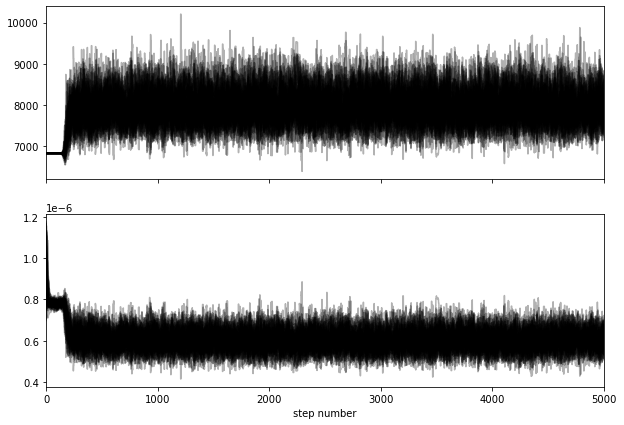

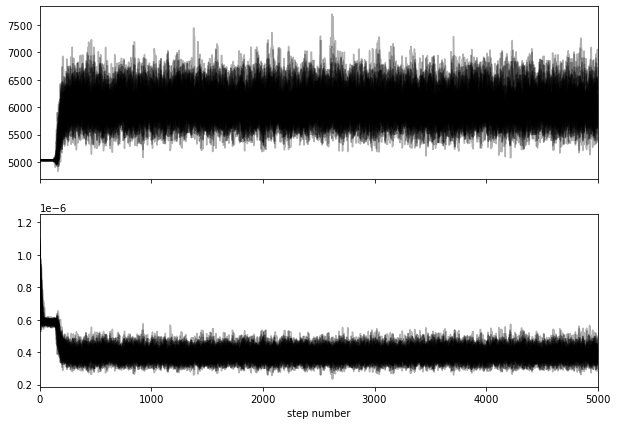

In [21]:
%matplotlib inline
plot_walker_emcee(samples_total)

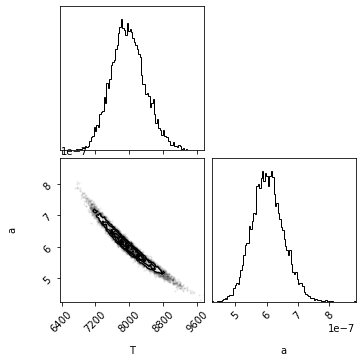

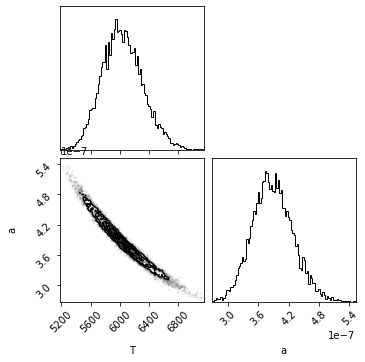

In [22]:
plot_corner_emcee(samplesflat_total)

In [25]:
results = display_median_from_chain(samplesflat_total) ##implement mode, mean 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [26]:
T_med = results[0][0]
a_med = results[2][0]


T_high = results[0][0] + results[1][0][1]
T_low = results[0][0] - results[1][0][0]
a_high = results[2][0] + results[3][0][0]
a_low = results[2][0] - results[3][0][0]


In [27]:
T_med2 = results[0][1]
a_med2 = results[2][1]


T_high2 = results[0][1] + results[1][1][1]
T_low2 = results[0][1] - results[1][1][0]
a_high2 = results[2][1] + results[3][1][0]
a_low2 = results[2][1] - results[3][1][0]

/home/aaronmaas/Desktop/Flares_Trappist/notebooks/funcs/blackbody_model.py:6: RuntimeWarning: overflow encountered in exp
  flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)
/home/aaronmaas/Desktop/Flares_Trappist/notebooks/funcs/blackbody_model.py:6: RuntimeWarning: overflow encountered in exp
  flare_contribution = (a*R_star)**2/(np.exp((c.h * c.c)/(T_flare*c.k*wavelength)) -1)


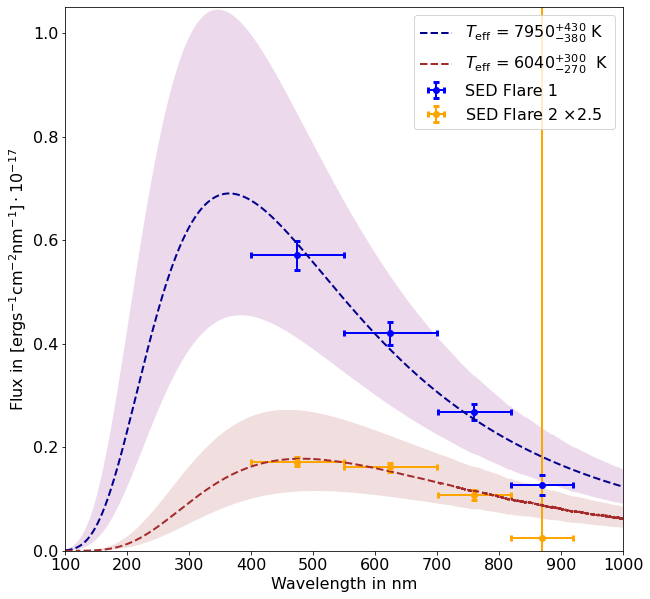

In [48]:
lc = [4.745e-07, 6.245e-07, 7.6e-07, 8.695000000000001e-07]
ranges = np.asarray([1.4999999999999994e-07, 1.5000000000000005e-07, 1.1900000000000005e-07, 1e-07])/2*1e9

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.rcParams['font.size'] = '16'

#4890.07968612]), array([5086.15002762
up = 1e17*brightness_mod_continous(wavelength_SED,T_high, a_high, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)
low = 1e17*brightness_mod_continous(wavelength_SED,T_low, a_low, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)


plt.errorbar(np.asarray(wavelength_M2)*1e9,1e17*brightness_flares[0]/limitss, xerr = ranges, yerr = 1e17*brightnesserror_flares[0]/limitss ,fmt=".b", \
                         ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = "SED Flare 1")

plt.plot(wavelength_SED*1e9,  \
         1e17*brightness_mod_continous(wavelength_SED, T_med, a_med, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $7950^{+430}_{-380}$ K", linewidth = 2, color = "darkblue") #, array([5127.88550742]

plt.fill_between(wavelength_SED*1e9, up, low, facecolor = "purple", alpha = 0.15)

plt.xlim(100,1000)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-12}$")



up2 = 2.5*brightness_mod_continous(wavelength_SED,T_high2, a_high2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)*1e17
low2 = 2.5*brightness_mod_continous(wavelength_SED,T_low2, a_low2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)*1e17

plt.errorbar(np.asarray(wavelength_M2)*1e9,2.5*brightness_flares[1]*1e17/limitss, xerr = ranges, yerr = 2.5*brightnesserror_flares[1]*1e17/limitss ,color="orange", \
                         ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = r"SED Flare 2 $\times 2.5$")

plt.plot(wavelength_SED*1e9,  \
         1e17*2.5*brightness_mod_continous(wavelength_SED, T_med2, a_med2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $6040^{+300}_{-270}$  K", linewidth = 2, color = "brown") #, array([5127.88550742]



plt.fill_between(wavelength_SED*1e9, up2, low2, facecolor = "brown", alpha = 0.15,)

plt.xlim(100,1000)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-17}$")
plt.ylim(0,1.05)

plt.legend(loc = "upper right", frameon = "True") 



In [ ]:
# Notes: 

'''



'''